In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

# Root directory of the project
#ROOT_DIR = os.getcwd()
ROOT_DIR = '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO'
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO')

# Path to trained weights file
# Download this file and place in the root of your 
# project (See README file for details)
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")  #mask_rcnn_coco_0025.h5
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_0115.h5")


# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

Using TensorFlow backend.


In [2]:
PYCOCO_DIR = '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO/PythonAPI'
sys.path.append(PYCOCO_DIR)

# MS COCO Dataset
import coco_stuff as coco
config = coco.CocoConfig()
COCO_DIR = "/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/2017"  # TODO: enter value here

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    93
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "minival")

# Must call before using the dataset
dataset.prepare()
print("Images: {}".format(len(dataset.image_ids)))

Image Directory:  /Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/2017/val2017
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
Images: 500


In [7]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 500
Classes: ['BG', 'banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other', 'table', 'tent', 'textile-other', 'towel', 'tree', 'vegetable', 'wall-brick', 'wall-concrete', 'wall-other', 'wall-panel', 'wall-stone', 'wall-tile', 'wall-wood',

In [8]:
#ROOT_DIR = '/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO/PythonAPI'

#sys.path.append(ROOT_DIR)

#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco_0025.h5")

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
if config.NAME == "shapes":
    weights_path = SHAPES_MODEL_PATH
elif config.NAME == "coco":
    weights_path = COCO_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/repos/Deep_COCO_repo/Deep-COCO/mask_rcnn_coco_0025.h5


## Inspect a Random Image

274
image ID: coco.87038 (274) http://cocodataset.org/#explore?id=87038
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 101)              min:    0.00000  max: 1024.00000
gt_class_id              shape: (6,)                  min:    5.00000  max:   92.00000
gt_bbox                  shape: (6, 4)                min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000


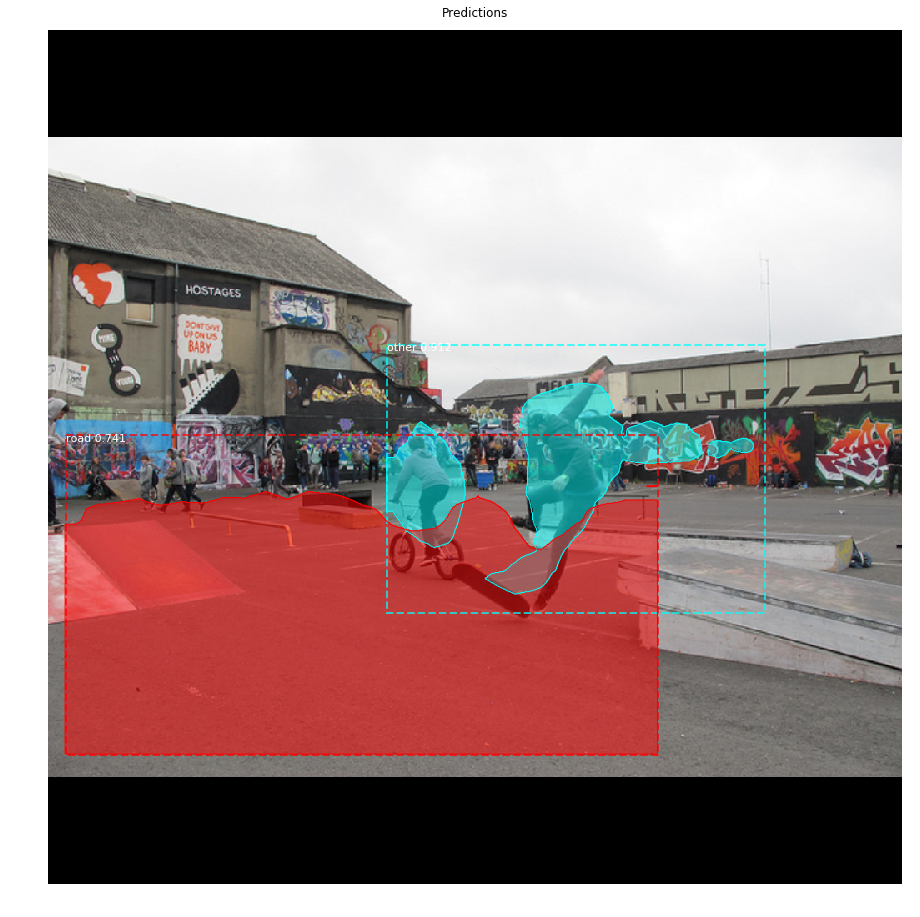

In [9]:
#image_id = random.choice(dataset.image_ids)
image_id = 274  #, 210, 48
print(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

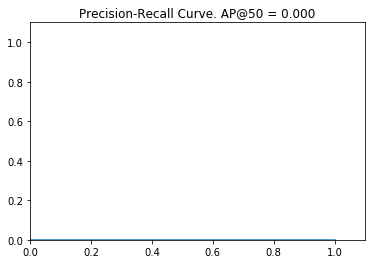

In [10]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)

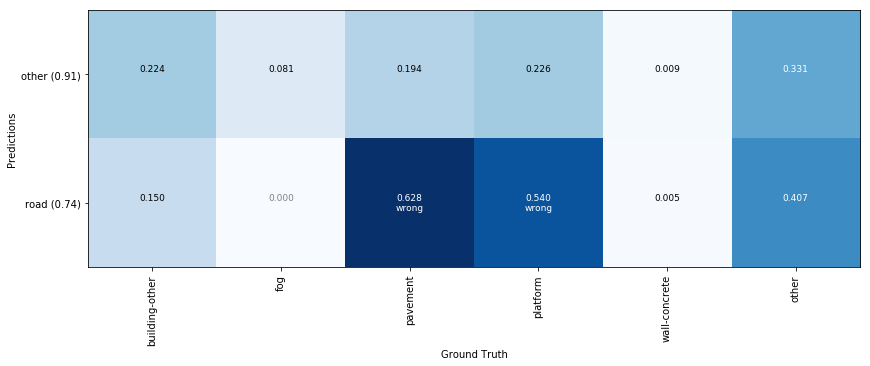

In [11]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

In [13]:
import json
with open('/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/analysis/aggregate_overlap_0025_512.json', 'r') as fp:
    data = json.load(fp)

fp.close()
data

{'building-other': {'building-other': [0.8422578623939972],
  'bush': [0.006912773368765037],
  'fence': [0.08093124890405601],
  'fog': [0.3950628273938795],
  'light': [0.029484405295856258],
  'other': [0.6454504565949116],
  'pavement': [0.013548122842315154],
  'road': [0.019745912129317873],
  'roof': [0.03143974686165161],
  'tree': [0.1445869708817596]},
 'ceiling-other': {'building-other': [0.0016768044316515505,
   0.12147617852139196],
  'cabinet': [0.14167337198032295,
   0.11008654805186448,
   0.0,
   0.0,
   0.09153347048583636,
   0.0,
   0.0,
   0.0,
   0.010878664717644865,
   0.0,
   0.12745712311941265,
   0.05818982464417709,
   0.0,
   0.21810292876943474,
   0.09418639951426837],
  'cardboard': [0.0, 0.1066405514046226],
  'carpet': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'ceiling-other': [0.8108108108108109,
   0.6446735395189004,
   0.89244689640468,
   0.0,
   0.0,
   0.6151108787872696,
   0.5994641012396694,
   0.5059944315159575,
   0.9035755504261364,
   0.

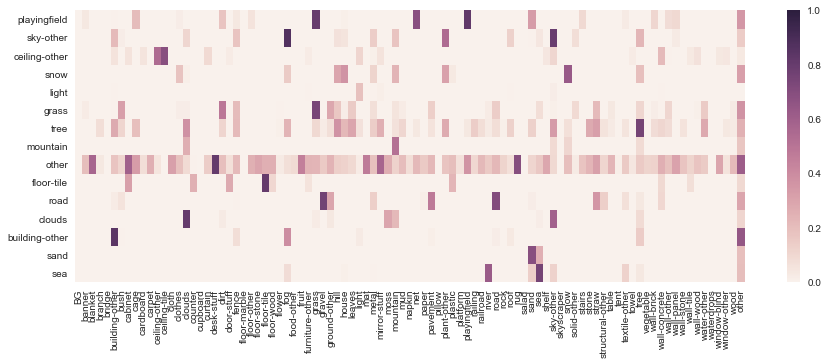

In [15]:
import pandas as pd
import seaborn as sns


overlap_map = pd.DataFrame(columns=dataset.class_names, index=data.keys())
for pred_class in data.keys():
    for gt_class in data[pred_class].keys():
        #print("{} : {} = {}".format(pred_class, gt_class, np.mean(agg_overlaps[pred_class][gt_class])))
        overlap_map.loc[pred_class][gt_class] = np.mean(data[pred_class][gt_class])
        
overlap_map.fillna(0, inplace=True)    

fig = plt.figure(figsize=(15,5))
ax = fig.gca()

ax = sns.heatmap(data=overlap_map, vmin=0, vmax=1)
plt.show()

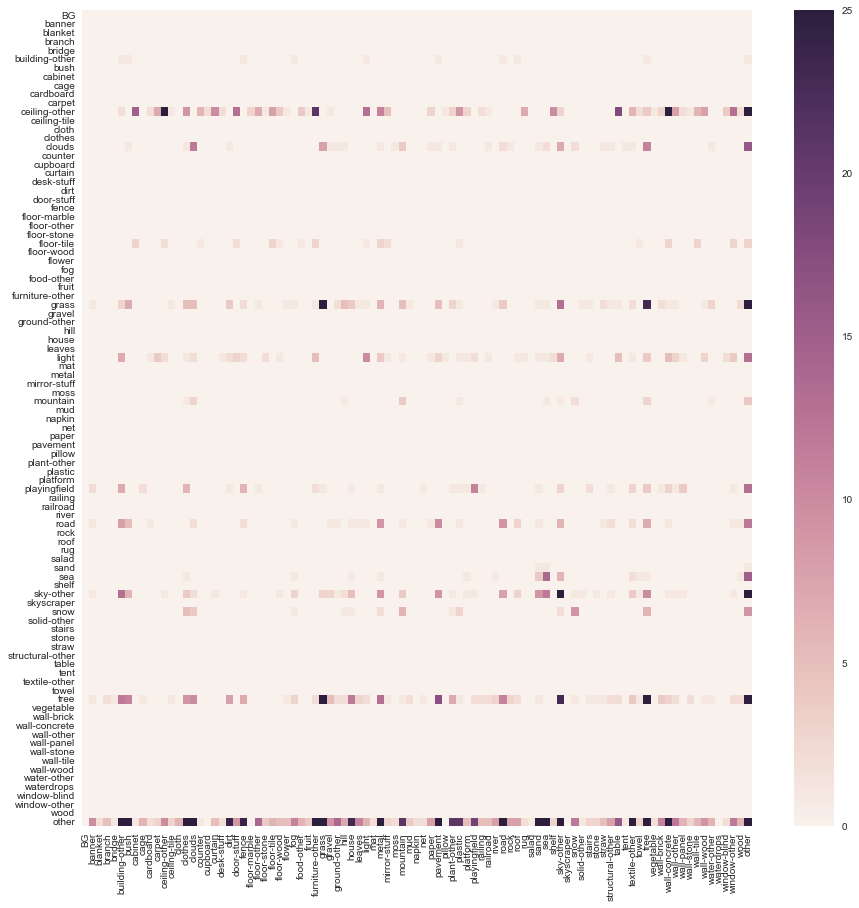

In [55]:
cm = pd.DataFrame(index=dataset.class_names, columns=dataset.class_names)

for pred_cid in data:
    #print("{} : {}".format(pred_cid, len(agg_overlaps[pred_cid])))
    for gt_cid in data[pred_cid]:
        #print("{}, {} : {}".format(pred_cid, gt_cid, len(agg_overlaps[pred_cid][gt_cid])))
        cm.loc[pred_cid][gt_cid] = len(data[pred_cid][gt_cid])
        
cm.fillna(0, inplace=True)
fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax = sns.heatmap(data=cm, vmin=0, vmax=25)
plt.show()

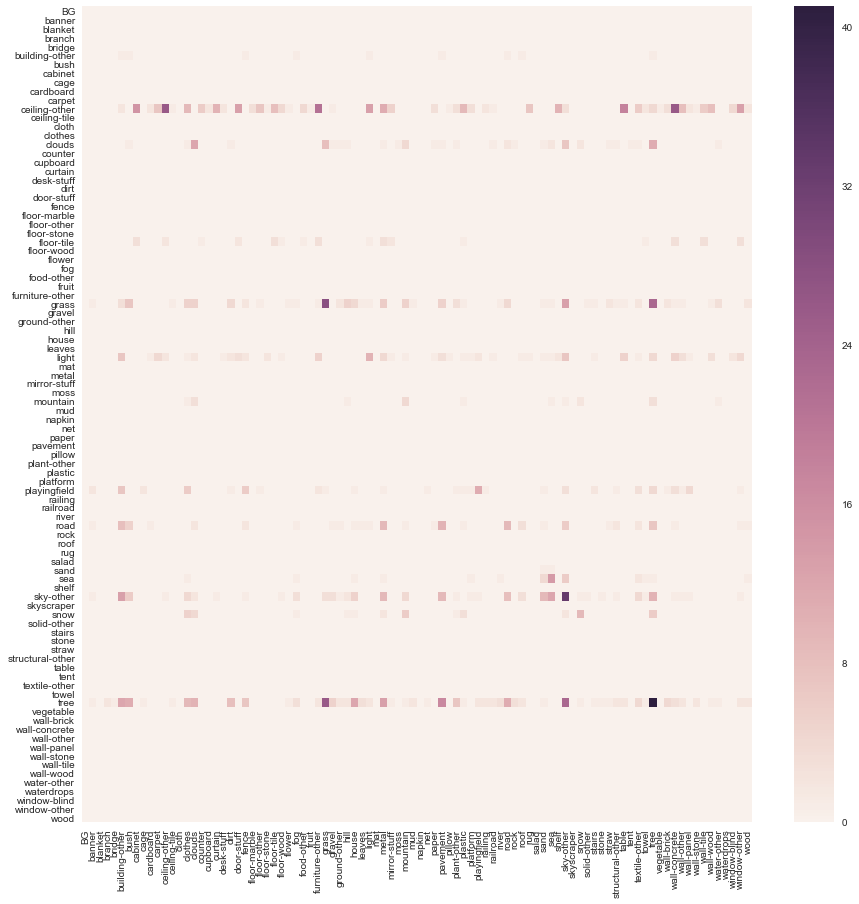

In [19]:
cm_no_other = cm.drop('other', axis=1)
cm_no_other = cm_no_other.drop('other', axis=0)

fig = plt.figure(figsize=(15,15))
ax = fig.gca()

ax = sns.heatmap(data=cm_no_other)
plt.show()

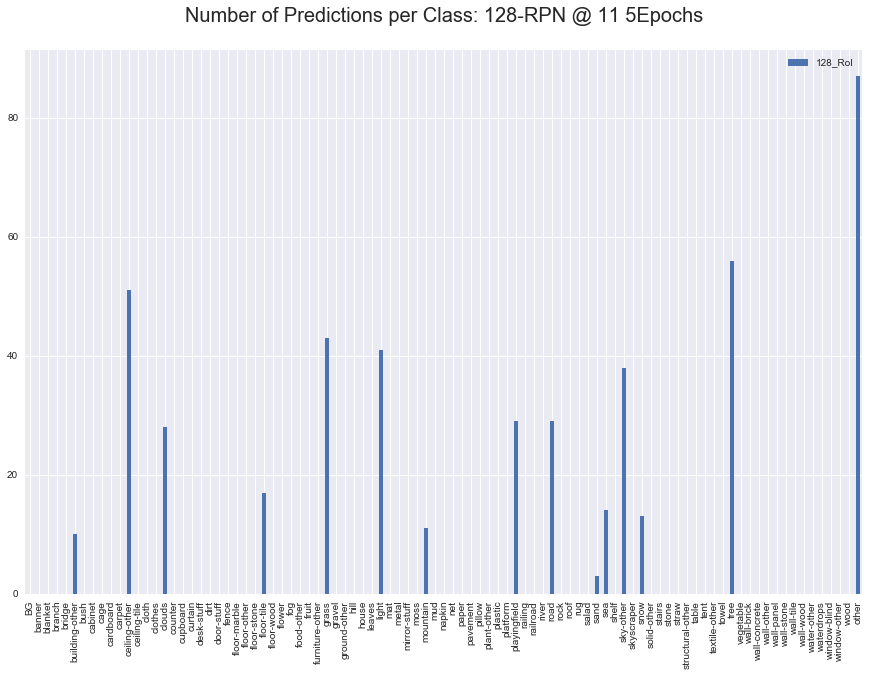

In [58]:
predict_dist = pd.DataFrame(columns=['128_RoI','256_RoI', '512_RoI'], index=dataset.class_names)

for pred_cid in data:
    #print("{} : {}".format(pred_cid, len(agg_overlaps[pred_cid])))
    predict_dist.loc[pred_cid]['128_RoI'] = 0
    for gt_cid in data[pred_cid]:
        #print("{}, {} : {}".format(pred_cid, gt_cid, len(agg_overlaps[pred_cid][gt_cid])))
        predict_dist.loc[pred_cid]['128_RoI'] += 1

predict_dist.fillna(0, inplace=True)

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

# Plot the bars for count
predict_dist[['128_RoI']].plot.bar(ax=ax)

# put the title on
ax.set_title('Number of Predictions per Class: 128-RPN @ 11 5Epochs\n', fontsize=20)


plt.show()



In [56]:
with open('/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/analysis/aggregate_overlap_0025_256.json', 'r') as fp:
    data_256 = json.load(fp)

fp.close()

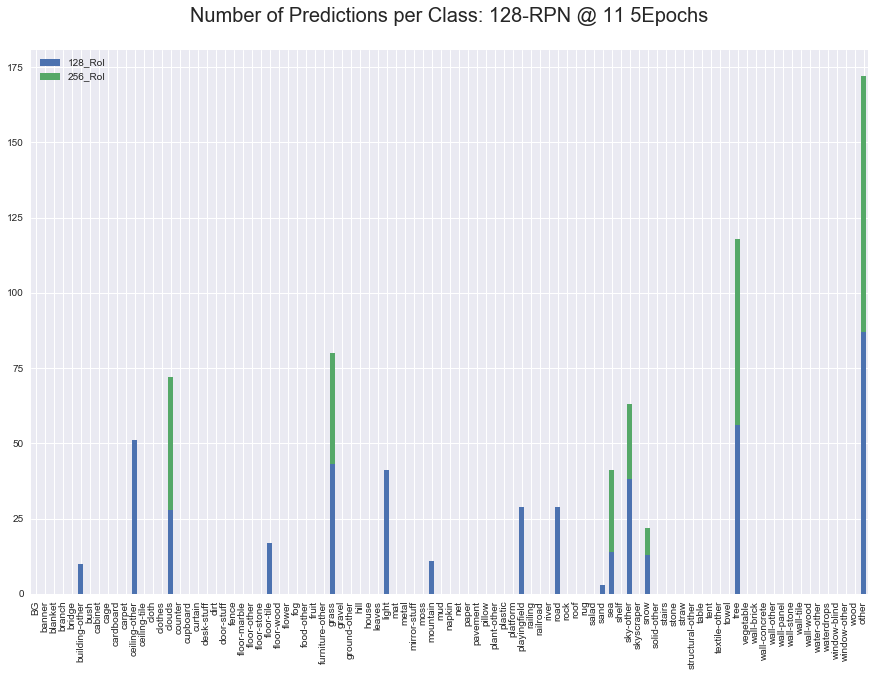

In [59]:
for pred_cid in data_256:
    #print("{} : {}".format(pred_cid, len(agg_overlaps[pred_cid])))
    predict_dist.loc[pred_cid]['256_RoI'] = 0
    for gt_cid in data_256[pred_cid]:
        #print("{}, {} : {}".format(pred_cid, gt_cid, len(agg_overlaps[pred_cid][gt_cid])))
        predict_dist.loc[pred_cid]['256_RoI'] += 1

predict_dist.fillna(0, inplace=True)

fig = plt.figure(figsize=(15,10))
ax = fig.gca()

# Plot the bars for count
predict_dist[['128_RoI','256_RoI']].plot.bar(stacked=True, ax=ax)

# put the title on
ax.set_title('Number of Predictions per Class per RoI Configuration\n', fontsize=20)


plt.show()


In [60]:
with open('/Users/carlosbeas/Desktop/Deep_Learning/COCO_Project/data/analysis/aggregate_overlap_0025_512.json', 'r') as fp:
    data_512 = json.load(fp)

fp.close()

In [ ]:
for pred_cid in data_512:
    #print("{} : {}".format(pred_cid, len(agg_overlaps[pred_cid])))
    predict_dist.loc[pred_cid]['512_RoI'] = 0
    for gt_cid in data_512[pred_cid]:
        #print("{}, {} : {}".format(pred_cid, gt_cid, len(agg_overlaps[pred_cid][gt_cid])))
        predict_dist.loc[pred_cid]['512_RoI'] += 1

predict_dist.fillna(0, inplace=True)

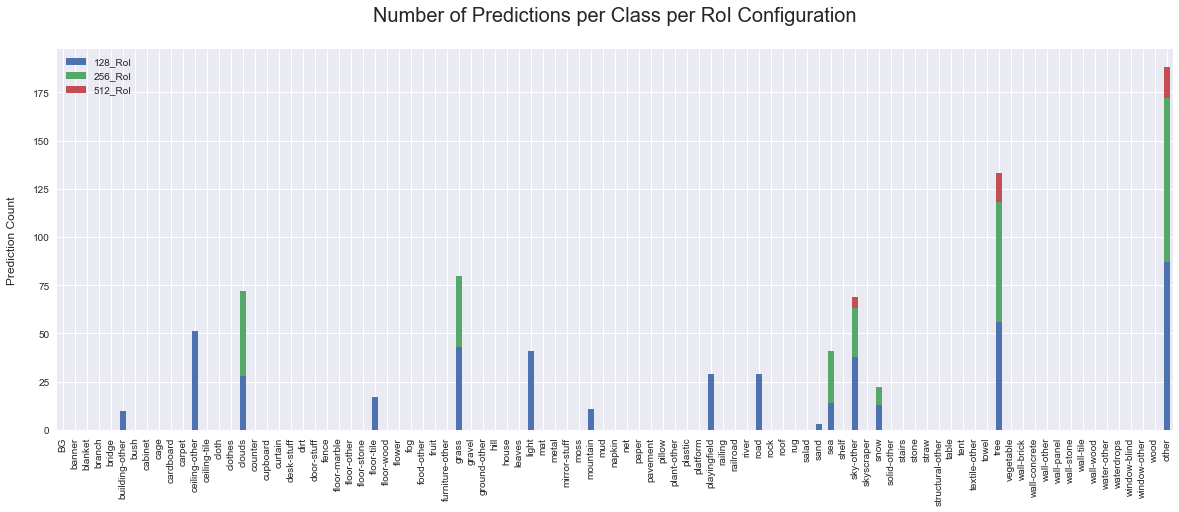

In [64]:
fig = plt.figure(figsize=(20,7))
ax = fig.gca()

# Plot the bars for count
predict_dist[['128_RoI','256_RoI','512_RoI']].plot.bar(stacked=True, ax=ax)

# put the title on
ax.set_title('Number of Predictions per Class per RoI Configuration\n', fontsize=20)
ax.set_ylabel('Prediction Count\n', fontsize=12)

plt.show()